In [1]:
## Parameters specific to where your folders are and your data
parameter_file = '../../parameters/params.yaml'
import yaml
import sys
import scipy.stats as stats
with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

#data_folder = doc['data_folder']
#tissues = doc['tissues'].split(',')
#sys.path.append(doc['pipeline_path'])
ref_fa = doc['GENOME_FA']
#anno_gff=doc['annotation']


import os
from os.path import join
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
import tqdm

from os.path import basename
##mpl.use('Agg')
#mpl.style.use('ggplot')
#mpl.style.use('fivethirtyeight')
from tss.visualize import plot_tss_results 
from tss.visualize.fig_utils import helper_save
## Plotting attributes
sns.set_style("whitegrid", {'axes.grid' : False})

from tss.data import annotation
from tss.visualize.fig_utils import helper_save

/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/ipykernel_launcher.py:7: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  import sys


params {'PREFIX': 'ncbi_pice_103', 'ROOT_DIR': '/data/isshamie/TSS/', 'DATA_DIR': '/data/isshamie/TSS/NCBI_PICR_103_Processed/', 'DATA_PROCESSED_DIR': '/data/isshamie/TSS/TSS/data/processed/', 'SUPPLEMENTAL_DIR': '/data/isshamie/TSS/Analysis/supplemental/', 'PIPELINE': '/data/isshamie/TSS/tss', 'GENOME_DIR': '/data/isshamie/genome', 'GENOME_FA': '/data/isshamie/genome/picr.fa', 'GENOME_GFF3': '/data/isshamie/genome/updated_final_sort.gff3', 'GENOME_GTF': '/data/isshamie/genome/updated_final_sort.gtf', 'TISSUES': 'BMDM1hKLA,BMDMwt,Brain,FemaleReproductive,Heart,Intestine,', 'META_FILE': '/data/isshamie/TSS/TSS/parameters/raw_metaSamples.tsv'}
fig_utils from mplh
/data2/resources/software/homer/v4.11_10242019/bin//


In [2]:
from matplotlib_venn import venn3

In [3]:
from matplotlib_venn import venn2

from tss.data import generate_genome
from tss.data.cumsum import *

### Indir

In [4]:
genome = "GCF"
os.chdir(doc["results"])
f_in = 'GCF/gene_centric_tss/gene_df_tissues.p'
TSS1_meta = join("GCF","eTSS","TSS.meta.tsv")
tissues_expression_f = "GCF/tissues_collapse/tissues.merge.peaksexpression"

#Peak annotation
annoPeaks_f = join('GCF', 'merged','samples.merge.anno')
peaks_expr_f = join('GCF','merged','tissues.merge.peaksexpression')
peaks_with_distance_noCDS = 'GCF/merged/peaks_with_tss_distances_size1.noCDS.tsv'

all_genes_f = join("GCF","genome","all_genes.tsv")
#init_anno_f = doc["alt_annotation"]
init_anno_f = '/data/isshamie/genome/hamster/ncbi_anno_103/GCF_003668045.1_CriGri-PICR/GCF_003668045.1_CriGri-PICR_genomic.gff'


### Outdir

In [5]:
os.chdir(doc["results"])
fig1_peaks = "figure1_summary"
if not os.path.exists(fig1_peaks):
    os.mkdir(fig1_peaks)

fig1_peaks = join(fig1_peaks,genome)
if not os.path.exists(fig1_peaks):
    os.mkdir(fig1_peaks)
    
thresh=0
venn_f = join(fig1_peaks, f"CHO_peaks_venn_thresh{thresh}.csv")
cumulative_f = join(fig1_peaks, f"CHO_cumulative_peaks_thresh{thresh}.csv")
mrna_out_f = join(fig1_peaks, f"CHO_mRNA_cumulative_peaks_thresh{thresh}.csv")

## Load

In [6]:
expr_df = pd.read_csv(tissues_expression_f,sep="\t",index_col = 0)

annoPeaks = pd.read_csv(annoPeaks_f,sep="\t",index_col=0)
annoPeaks = annoPeaks.dropna(subset=['Annotation'])
#annoPeaks = annoPeaks[annoPeaks["Annotation"].str.contains("promoter")]
annoPeaks

,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,Entrez ID,Nearest Unigene,Nearest Refseq,Nearest Ensembl,Gene Name,Gene Alias,Gene Description,Gene Type
PeakID (cmd=annotatePeaks.pl data/processed/GCF/merged/samples.merge /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/hamster/ncbi_anno_103/GCF_003668045.1_CriGri-PICR/GCF_003668045.1_CriGri-PICR_genomic.gff),,,,,,,,,,,,,,,,,,
539323,NW_020822460.1,1084630,1084782,+,66162.929688,MiscOrgans_START1_and_MiscOrgans_startinput1|L...,promoter-TSS (ID=exon-XR_003482412.1-1;Parent=...,-promoter-TSS (ID=exon-XR_003482412.1-1;Parent...,-1.0,ID=exon-XR_003482412.1-1;Parent=rna-XR_0034824...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
353477,NW_020822618.1,401845,402000,-,21905.132812,MiscOrgans_START1_and_MiscOrgans_startinput1|L...,promoter-TSS (ID=exon-XR_003487470.1-1;Parent=...,-promoter-TSS (ID=exon-XR_003487470.1-1;Parent...,4.0,ID=exon-XR_003487470.1-1;Parent=rna-XR_0034874...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,NW_020822410.1,4827637,4827815,+,20179.468750,MiscOrgans_START1_and_MiscOrgans_startinput1|L...,promoter-TSS (ID=exon-XM_027391402.1-1;Parent=...,-promoter-TSS (ID=exon-XM_027391402.1-1;Parent...,-11.0,ID=exon-XM_027391402.1-1;Parent=rna-XM_0273914...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
349134,NW_020822505.1,689618,689773,-,18150.236328,Brain_GROCap1_and_Brain_GRO1|Heart_START1_and_...,promoter-TSS (ID=exon-XR_003483964.1-10;Parent...,-promoter-TSS (ID=exon-XR_003483964.1-10;Paren...,3.0,ID=exon-XR_003484049.1-1;Parent=rna-XR_0034840...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
300005,NW_020822602.1,9283364,9283514,+,15297.872070,MiscOrgans_START1_and_MiscOrgans_startinput1|B...,promoter-TSS (ID=exon-XM_027422995.1-6;Parent=...,-promoter-TSS (ID=exon-XM_027422995.1-6;Parent...,0.0,ID=exon-XR_003486731.1-1;Parent=rna-XR_0034867...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288830,NW_020822605.1,1766806,1766956,+,0.299000,CHO_START1_and_CHO_startinput1,Intergenic,Intergenic,1595.0,ID=exon-XM_027423920.1-2;Parent=rna-XM_0274239...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
290498,NW_020822423.1,1137717,1137867,+,0.299000,CHO_START1_and_CHO_startinput1,Intergenic,Intergenic,7553.0,ID=exon-XM_027393643.1-18;Parent=rna-XM_027393...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
305615,NW_020822519.1,31154352,31154647,-,0.294000,CHO_START1_and_CHO_startinput1|CHO_GROCap1_and...,Intergenic,Intergenic,-62774.0,ID=exon-XM_027411385.1-1;Parent=rna-XM_0274113...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
all_genes = set(pd.read_csv(all_genes_f,index_col=None,header=None)[0].values)
all_genes

{'Adssl1',
 'Cdk13',
 'Vps41',
 'LOC113837291',
 'Cltb',
 'Gpr155',
 'Acp4',
 'Srebf1',
 'LOC113837293',
 'Opa1',
 'LOC113839142',
 'LOC113831565',
 'LOC100775072',
 'Urb1',
 'LOC100772575',
 'Stam',
 'Cse1l',
 'LOC100761100',
 'LOC100768089',
 'Fscn1',
 'Cnbp',
 'Usp13',
 'LOC113834415',
 'Coq2',
 'LOC100752309',
 'Trim44',
 'Slc44a2',
 'Hoga1',
 'LOC100765576',
 'LOC100770391',
 'Prg4',
 'Dgkz',
 'Fam167a',
 'LOC100760210',
 'LOC100772455',
 'Vps37d',
 'Tcap',
 'Nek11',
 'Pde7a',
 'Ak7',
 'Ids',
 'LOC100756518',
 'Cdh2',
 'LOC100770032',
 'Zfpl1',
 'Ppif',
 'Cav3',
 'Greb1l',
 'LOC100753093',
 'LOC100751895',
 'LOC100759940',
 'LOC113838728',
 'LOC100756974',
 'LOC113838839',
 'LOC100752562',
 'Rangap1',
 'LOC100761689',
 'Hemk1',
 'Ccdc172',
 'LOC100760752',
 'Mpc2',
 'LOC113832204',
 'Lnx1',
 'Epor',
 'Bst1',
 'Angptl2',
 'Ino80',
 'LOC113837890',
 'Tcf23',
 'Plekhg2',
 'Btg1',
 'Dnttip2',
 'Aifm3',
 'Parp16',
 'Cpxm2',
 'Commd8',
 'Tex52',
 'LOC100756943',
 'Vav2',
 'Mrpl9',
 'Aic

### Plot the CDF of fraction of genes covered

In [8]:
all_peaks_n = dict()
all_peaks = dict()


## mRNA

In [9]:
tissues = doc["global"]["TISSUES"]
tissues

['BMDM1hKLA',
 'BMDMwt',
 'Brain',
 'FemaleReproductive',
 'Heart',
 'Kidney',
 'Liver',
 'Lung',
 'MiscOrgans',
 'Muscle',
 'Pancreas',
 'Spleen',
 'CHO']

In [10]:
gene = pickle.load(open(f_in,"rb"), encoding='latin')

#gene["tissues"] = gene["samples"].apply(lambda x: to_collapse(x,tissue_map_short))
gene_bin = create_binary(gene,tissues,colname="Tissues")
cdf_number_gene,gene_tissues_order = create_cdf(gene_bin, start_tissues=("CHO",))

15308it [02:00, 126.55it/s]


In [11]:
gene["hasGene"].sum()

15308

In [12]:
mrna_peaks = {}
for t in gene_tissues_order:    
    col = t
    mrna_peaks[t] = set(gene_bin[~(gene_bin[col]==0)].index.values)


0
9850
13537
14204
14500
14727
14880
14983
15071
15144
15207
15249
15285


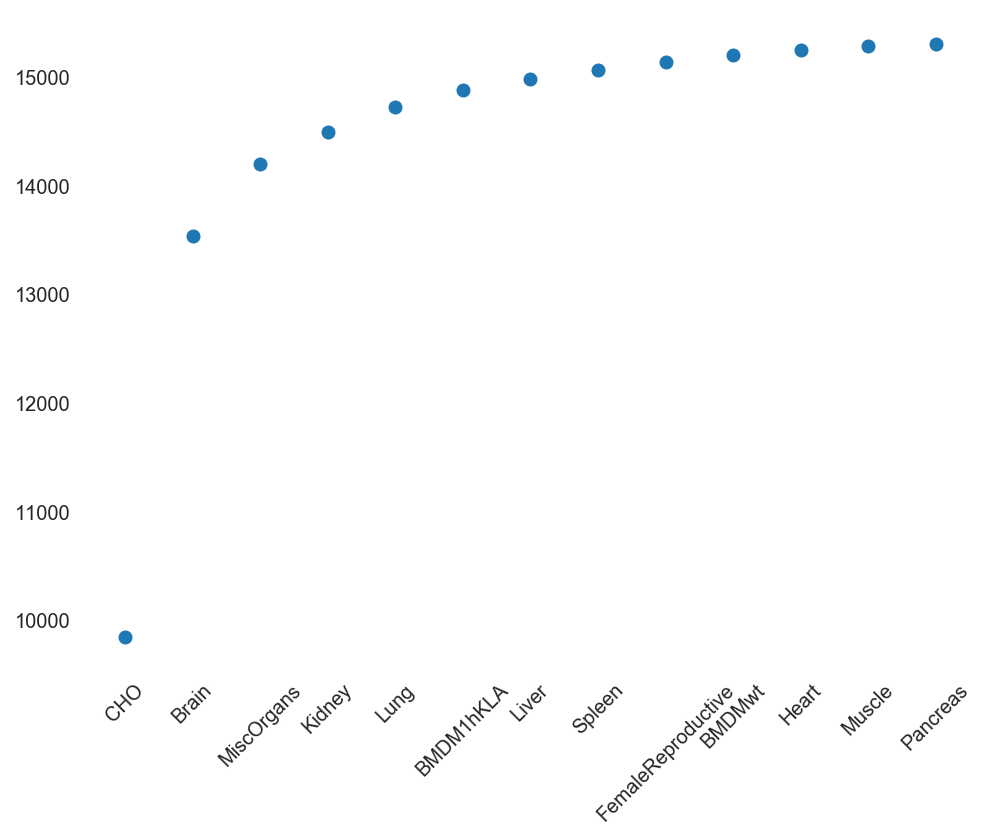

In [13]:
mrna_cum_peaks_n, mrna_cum_peaks = get_cum_and_plot(mrna_peaks, gene_tissues_order,f_save=mrna_out_f)

all_peaks_n['mRNA'] = mrna_cum_peaks_n
all_peaks['mRNA'] = mrna_peaks

In [29]:
all_peaks_n['mRNA'] 

[9850,
 13537,
 14204,
 14500,
 14727,
 14880,
 14983,
 15071,
 15144,
 15207,
 15249,
 15285,
 15308]

### All promoter TSS

/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


0
14291
21604
23050
24678
26123
27398
28171
28611
29085
29896
30326
30595


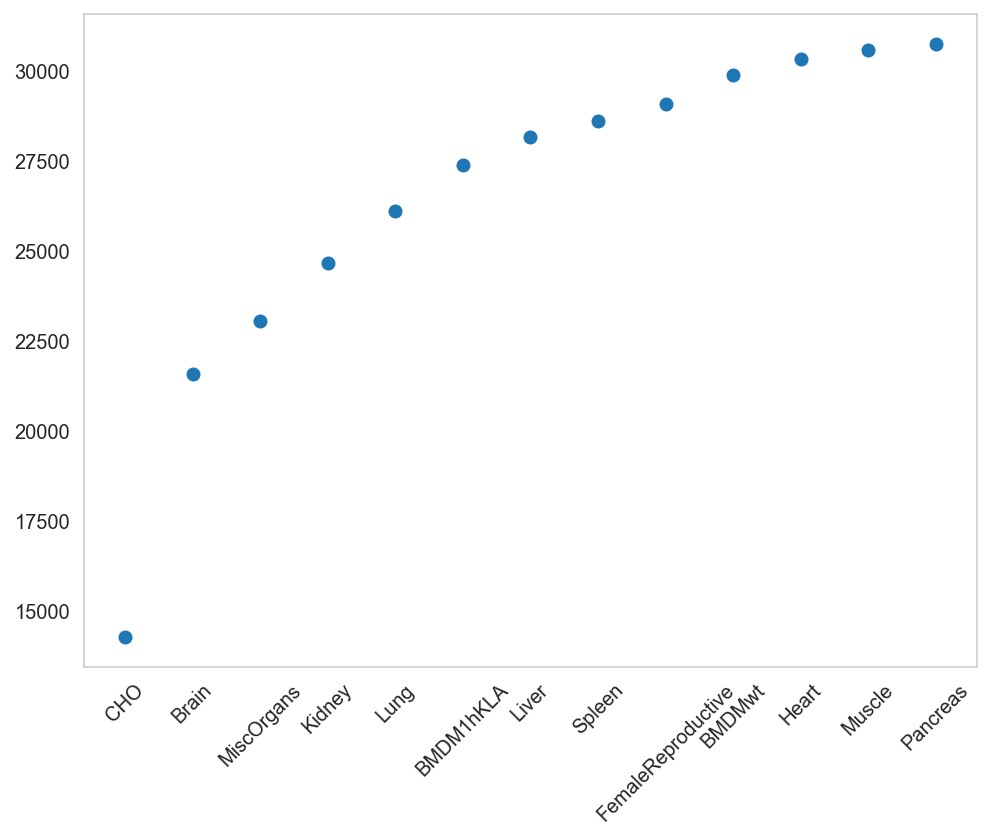

In [14]:
promoter_tss = pd.read_csv(TSS1_meta,sep="\t",index_col=0)["ID"].values
promoter_expr_df = expr_df.loc[promoter_tss]
promoter_tss


bin_df_prom = create_binary_from_expr(promoter_expr_df,threshold=thresh)
#cdf_number,cdf_tissues = create_cdf(bin_df_prom)

prom_peaks = {}
for t in gene_tissues_order:    
    col = t
    prom_peaks[t] = set(bin_df_prom[~(bin_df_prom[col]==0)].index.values)

prom_cum_peaks_n, prom_cum_peaks = get_cum_and_plot(prom_peaks, gene_tissues_order);
all_peaks_n['Promoter'] = prom_cum_peaks_n
all_peaks['Promoter'] = prom_peaks

## Enhancers:
1. Enhancer:  
   i. Annotation as intergenic  
   ii. Distance to TSS > 1000  
   iii. Need to handle same strand/divergent transcription  
2. Filter:  
   i. > 1 CPM  
   ii. > 10 CPM ??  
   iii. > 2 tissues  

In [15]:
intergenic = pd.read_csv("GCF/merged/samples.merge.anno",sep="\t",index_col=0)
#intergenic["Annotation"].filna(inplace=True)
intergenic = intergenic[(intergenic["Annotation"].str.contains("Intergenic") & (np.abs(intergenic["Distance to TSS"].fillna(0).astype(int)) > 1000))]

intergenic_expr_df = expr_df.loc[intergenic.index]
intergenic_expr_df

,MiscOrgans,Liver,Brain,Lung,Heart,CHO,Pancreas,BMDM1hKLA,FemaleReproductive,Muscle,Kidney,Spleen,BMDMwt
PeakID (cmd=annotatePeaks.pl data/processed/GCF/merged/samples.merge /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/hamster/ncbi_anno_103/GCF_003668045.1_CriGri-PICR/GCF_003668045.1_CriGri-PICR_genomic.gff),,,,,,,,,,,,,
21564,6353.05,15855.566667,0.000000,2013.210000,0.00,0.0000,992.90,0.0,1443.85,8095.50,5406.433333,997.65,0.0
91038,0.00,0.000000,0.000000,0.000000,0.00,0.0000,0.00,0.0,11888.75,4057.85,1970.233333,870.20,0.0
1060,30360.10,696.566667,5940.685714,322.700000,1604.65,1451.5130,19401.65,0.0,255.05,538.00,406.766667,272.95,0.0
167474,0.00,0.000000,0.000000,0.000000,5278.55,0.0000,0.00,0.0,4907.40,1704.40,1951.233333,1115.25,0.0
139598,2604.70,300.766667,9684.214286,1524.033333,1235.90,2664.2000,4222.05,1170.0,5534.45,3039.90,2507.066667,1242.95,2547.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
288830,0.00,0.000000,0.000000,0.000000,0.00,0.0598,0.00,0.0,0.00,0.00,0.000000,0.00,0.0
290498,0.00,0.000000,0.000000,0.000000,0.00,0.0598,0.00,0.0,0.00,0.00,0.000000,0.00,0.0
305615,0.00,0.000000,0.000000,0.000000,0.00,0.1176,0.00,0.0,0.00,0.00,0.000000,0.00,0.0


#### Distance to gene > 1000

0
59090
105160
119473
158651
186994
229675
250898
261144
276322
304987
320648
329270


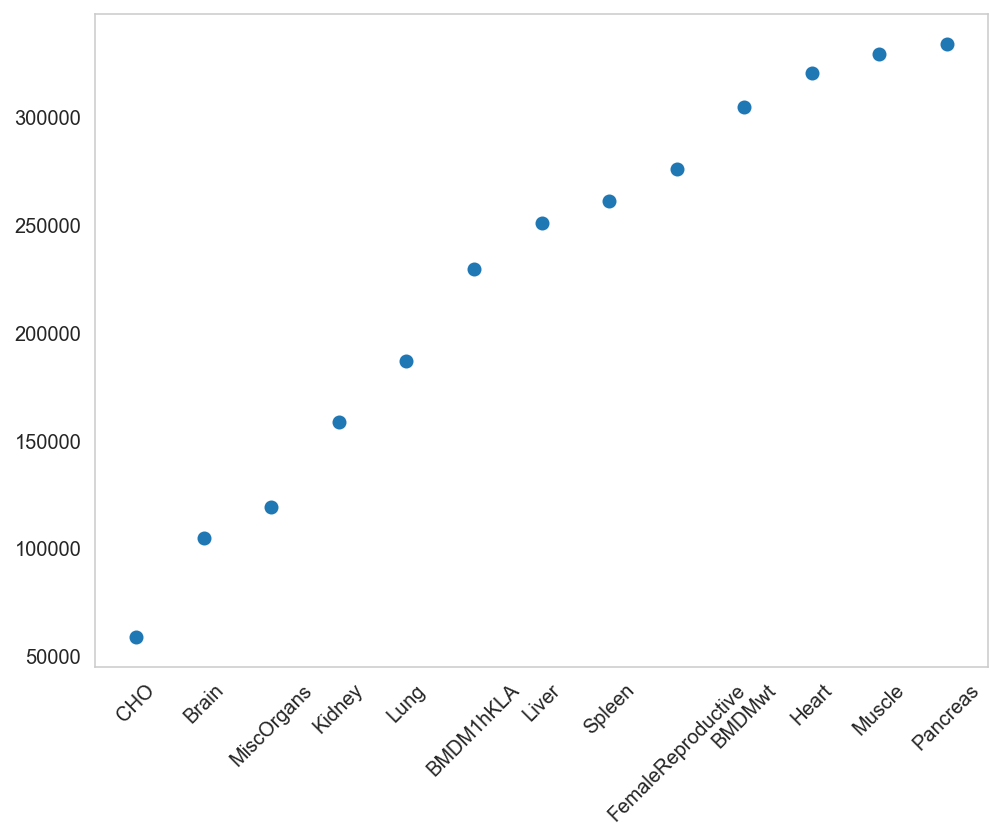

In [16]:
bin_df_enh = create_binary_from_expr(intergenic_expr_df,threshold=thresh)
#cdf_number,cdf_tissues = create_cdf(bin_df_enh)

distal_peaks = {}
for t in gene_tissues_order:    
    col = t
    distal_peaks[t] = set(bin_df_enh[~(bin_df_enh[col]==0)].index.values)

enh_cum_peaks_n, enh_cum_peaks = get_cum_and_plot(distal_peaks, gene_tissues_order);
all_peaks_n['Distal'] = enh_cum_peaks_n
all_peaks['Distal'] = distal_peaks

## ncRNA (annotated)

## Get information from annotation

In [17]:
print(init_anno_f)
anno_df = pd.read_csv(init_anno_f,sep="\t", header=None,comment="#")
anno_types = anno_df[2].unique()
not_include = ['mRNA','gene', 'region','exon','CDS','primary_transcript','guide_RNA',
               'pseudogene','transcript','match','cDNA_match']
anno_types_keep = set(anno_types) - set(not_include)

print(anno_types_keep)
anno_df_otherrna = anno_df[anno_df[2].isin(anno_types_keep)]
print(anno_df_otherrna.shape)
anno_df_otherrna = generate_genome.expand_anno_id(anno_df_otherrna)
anno_df_otherrna


/data/isshamie/genome/hamster/ncbi_anno_103/GCF_003668045.1_CriGri-PICR/GCF_003668045.1_CriGri-PICR_genomic.gff


171it [00:00, 1706.52it/s]

{'snoRNA', 'V_gene_segment', 'C_gene_segment', 'snRNA', 'lnc_RNA', 'miRNA', 'rRNA', 'tRNA'}
(8767, 9)


8767it [00:04, 2053.43it/s]


,0,1,2,3,4,5,6,7,8,ID,...,product,transcript_id,Note,anticodon,inference,standard_name,exception,end_range,partial,start_range
4,NW_020822366.1,Gnomon,lnc_RNA,269294,313331,.,+,.,ID=rna-XR_003479383.1;Parent=gene-LOC113832197...,rna-XR_003479383.1,...,uncharacterized LOC113832197%2C transcript var...,XR_003479383.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NW_020822366.1,Gnomon,lnc_RNA,551299,551829,.,+,.,ID=rna-XR_003479384.1;Parent=gene-LOC113832198...,rna-XR_003479384.1,...,uncharacterized LOC113832198,XR_003479384.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,NW_020822366.1,Gnomon,lnc_RNA,696459,713531,.,+,.,ID=rna-XR_003479386.1;Parent=gene-LOC103159926...,rna-XR_003479386.1,...,uncharacterized LOC103159926%2C transcript var...,XR_003479386.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NW_020822366.1,Gnomon,lnc_RNA,696459,713531,.,+,.,ID=rna-XR_003479388.1;Parent=gene-LOC103159926...,rna-XR_003479388.1,...,uncharacterized LOC103159926%2C transcript var...,XR_003479388.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,NW_020822366.1,Gnomon,lnc_RNA,710127,713531,.,+,.,ID=rna-XR_003479385.1;Parent=gene-LOC103159926...,rna-XR_003479385.1,...,uncharacterized LOC103159926%2C transcript var...,XR_003479385.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1277584,NW_020824166.1,Gnomon,V_gene_segment,30244,32178,.,+,.,ID=id-LOC113839139;Parent=gene-LOC113839139;Db...,id-LOC113839139,...,NaN,NaN,NaN,NaN,NaN,Ig heavy chain V region 3-6-like,NaN,NaN,NaN,NaN
1277593,NW_020824167.1,tRNAscan-SE,tRNA,20889,20960,.,+,.,ID=rna-Trnaa-ugc-14;Parent=gene-Trnaa-ugc-14;D...,rna-Trnaa-ugc-14,...,tRNA-Ala,NaN,transfer RNA alanine (anticodon UGC),(pos:20921..20923),COORDINATES: profile:tRNAscan-SE:1.23,NaN,NaN,NaN,NaN,NaN
1277684,NW_020824187.1,Gnomon,V_gene_segment,13199,14646,.,-,.,ID=id-LOC113839148;Parent=gene-LOC113839148;Db...,id-LOC113839148,...,NaN,NaN,NaN,NaN,NaN,Ig kappa chain V-II region 26-10-like,NaN,NaN,NaN,NaN
1277741,NW_020824193.1,Gnomon,V_gene_segment,12876,13513,.,+,.,ID=id-LOC113839152;Parent=gene-LOC113839152;Db...,id-LOC113839152,...,NaN,NaN,NaN,NaN,NaN,Ig kappa chain V-III region MOPC 63-like,NaN,NaN,NaN,NaN


In [18]:
ncrnas = annoPeaks[annoPeaks['Annotation'].fillna('').str.contains("ncRNA")]
ncrnas_prom = ncrnas[(ncrnas["Annotation"].fillna('').str.contains("promoter"))]
ncrnas_prom_expression = expr_df.loc[ncrnas_prom.index]
print(f"Number of ncrnas: {ncrnas.shape[0]}")
ncrnas_prom_expression = expr_df.loc[ncrnas_prom.index]

ncrnas_prom = ncrnas_prom.dropna(axis=1,how='all')
ncrnas_prom = generate_genome.expand_anno_id(ncrnas_prom,colname='Nearest PromoterID')


gene_ID = dict()
for biotype, df in anno_df_otherrna.groupby(2):
    print(biotype)
    gene_ID[biotype] = df['ID'].values

peak_ID = dict()
for i in gene_ID:
    print(i)
    print(f"Number of the type: {len(gene_ID[i])}")
    print('Parent')
    print(ncrnas_prom['Parent'].isin(gene_ID[i]).sum())

    peak_ID[i] = ncrnas_prom[ncrnas_prom['Parent'].isin(gene_ID[i])].index

peak_ID

58it [00:00, 577.46it/s]

Number of ncrnas: 12270


7101it [00:02, 2431.14it/s]


C_gene_segment
V_gene_segment
lnc_RNA
miRNA
rRNA
snRNA
snoRNA
tRNA
C_gene_segment
Number of the type: 9
Parent
0
V_gene_segment
Number of the type: 592
Parent
1
lnc_RNA
Number of the type: 5891
Parent
5597
miRNA
Number of the type: 291
Parent
90
rRNA
Number of the type: 22
Parent
0
snRNA
Number of the type: 871
Parent
447
snoRNA
Number of the type: 606
Parent
175
tRNA
Number of the type: 485
Parent
3


{'C_gene_segment': Int64Index([], dtype='int64', name='PeakID (cmd=annotatePeaks.pl data/processed/GCF/merged/samples.merge /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/hamster/ncbi_anno_103/GCF_003668045.1_CriGri-PICR/GCF_003668045.1_CriGri-PICR_genomic.gff)'),
 'V_gene_segment': Int64Index([164470], dtype='int64', name='PeakID (cmd=annotatePeaks.pl data/processed/GCF/merged/samples.merge /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/hamster/ncbi_anno_103/GCF_003668045.1_CriGri-PICR/GCF_003668045.1_CriGri-PICR_genomic.gff)'),
 'lnc_RNA': Int64Index([484565, 129410, 195062,  88219, 450911, 113553,   6896, 346530,
             276873, 451858,
             ...
             428957, 429720, 429708, 430879, 428439, 430693, 428483, 344967,
             343309, 429753],
            dtype='int64', name='PeakID (cmd=annotatePeaks.pl data/processed/GCF/merged/samples.merge /data/iss

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
0
2197
2915
3176
3765
4132
4494
4829
4970
5094
5331
5463
5555
0
10
43
44
56
58
58
66
66
67
72
86
87
0
0
0
0
0
0
0
0
0
0
0
0
0
0
193
258
269
321
332
364
382
397
415
430
439
441
0
30
80
84
91
107
120
129
132
138
157
167
171
0
1
1
1
1
2
3
3
3
3
3
3
3


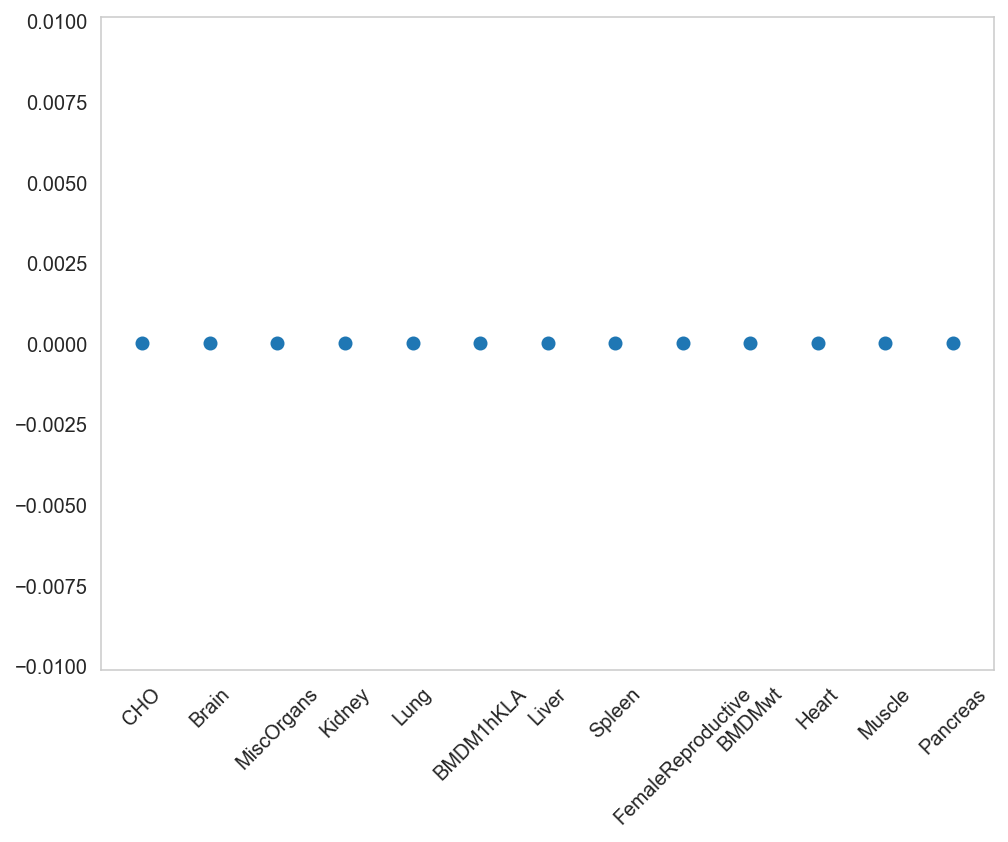

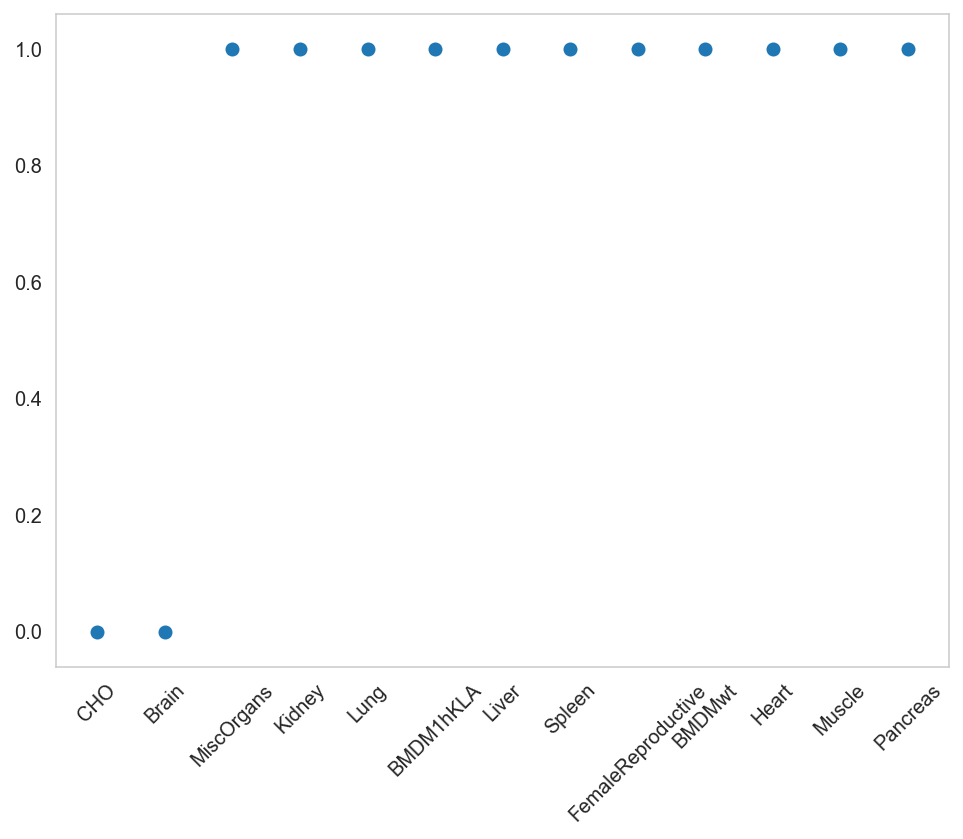

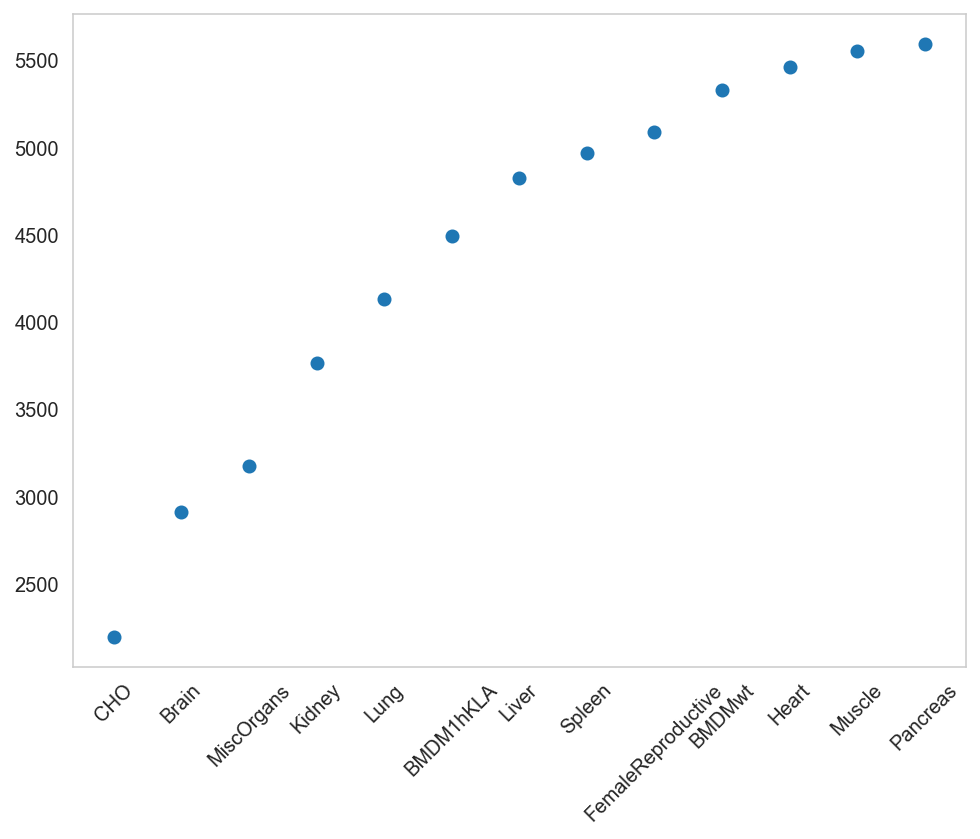

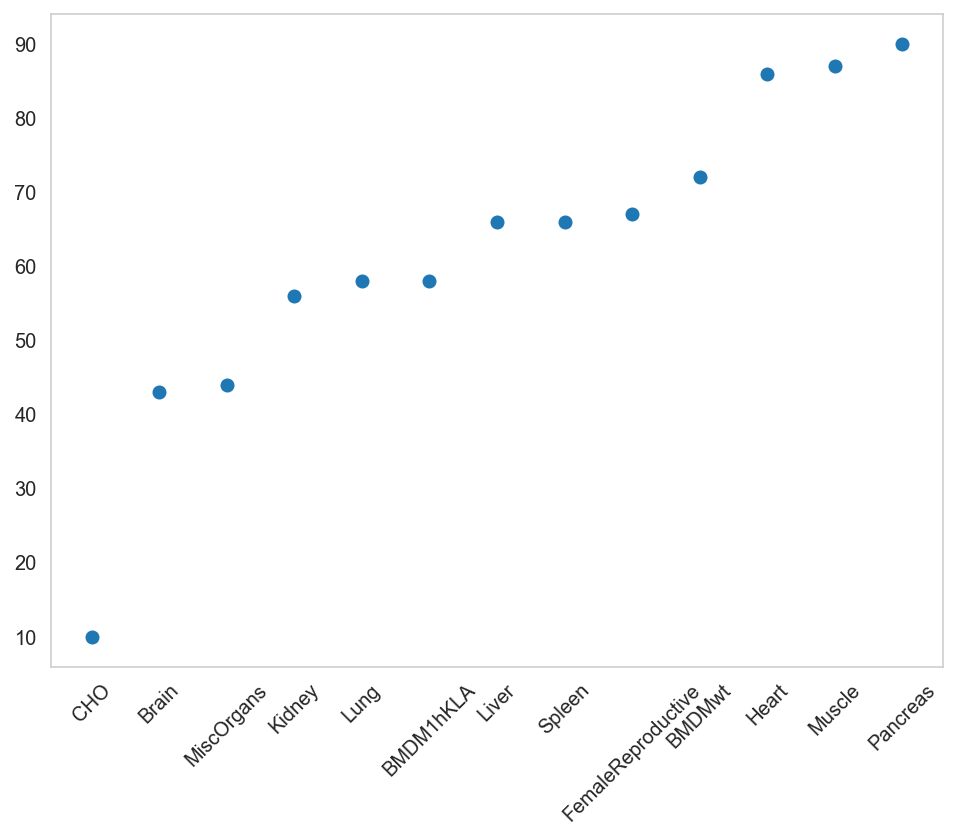

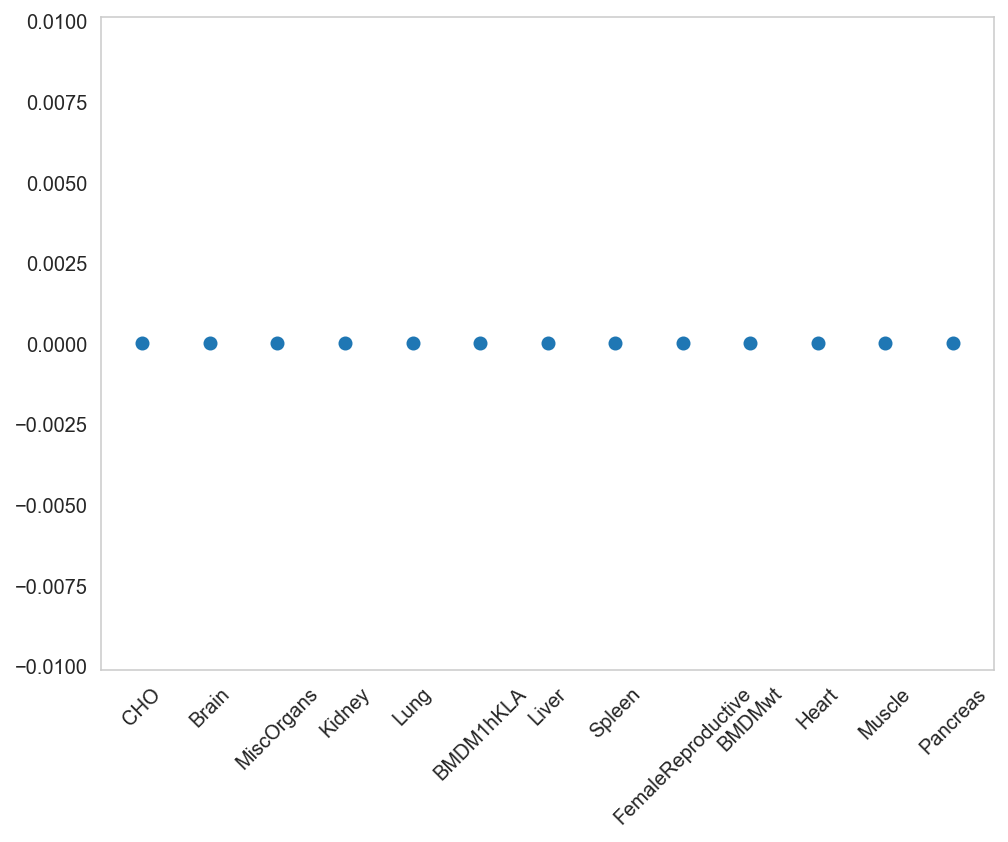

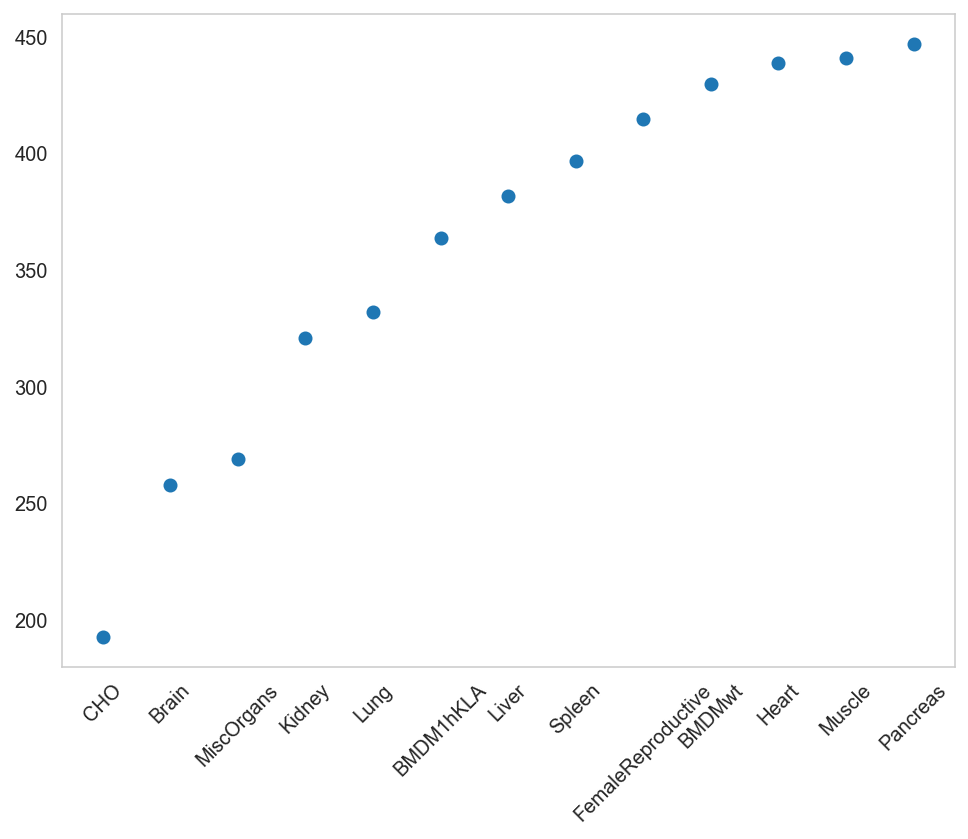

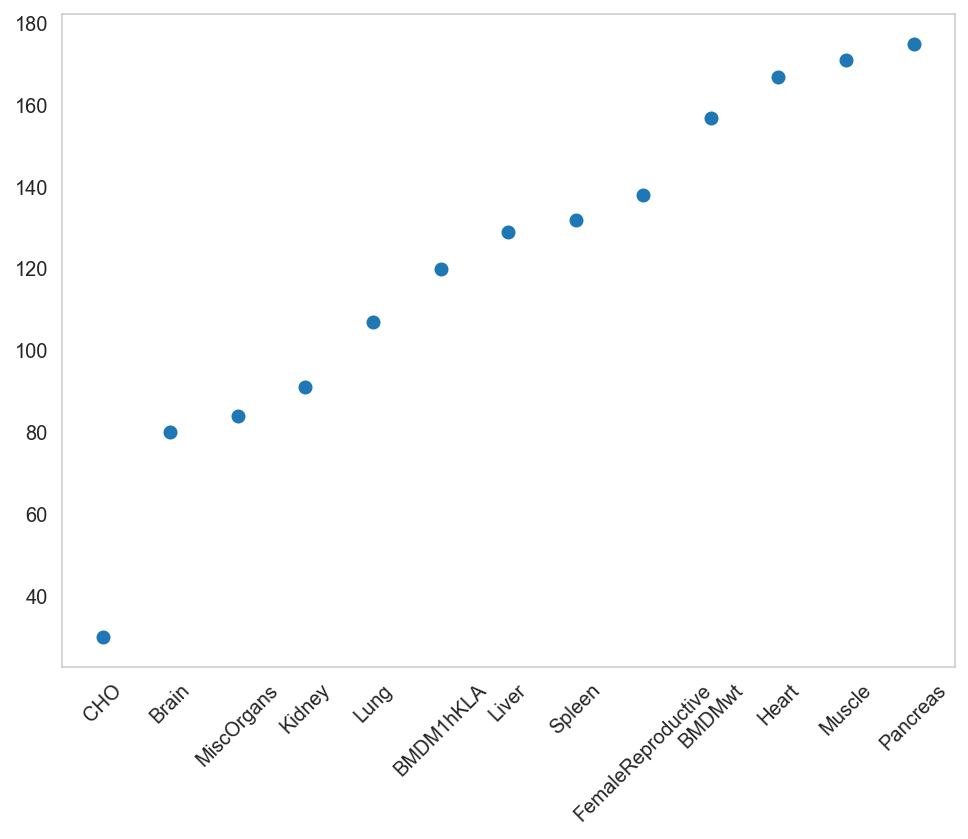

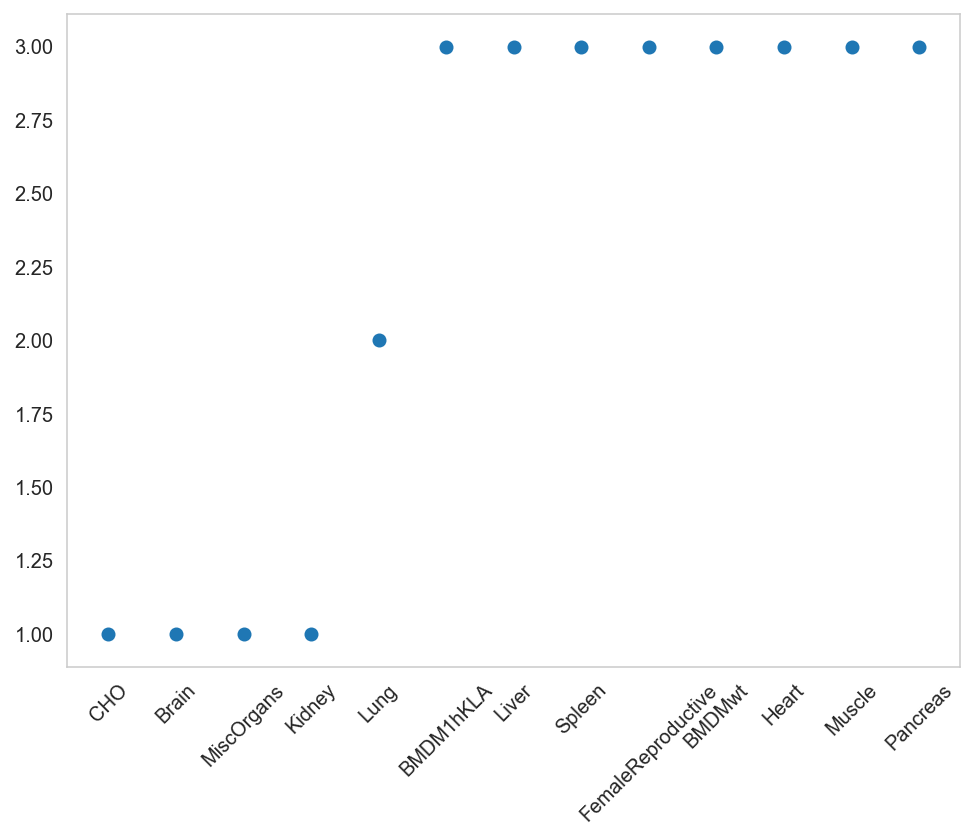

In [19]:
biotype_cum_peaks_n = dict()

for i in peak_ID:
    curr_bin_df = create_binary_from_expr(expr_df.loc[peak_ID[i]],threshold=thresh)

    # Tissue peaks
    curr_tissue_peaks = {}
    for t in gene_tissues_order:    
        col = t
        curr_tissue_peaks[t] = set(curr_bin_df[~(curr_bin_df[col]==0)].index.values)
    
    
    curr_cum_peaks_n, curr_cum_peaks = get_cum_and_plot(curr_tissue_peaks, gene_tissues_order);
    biotype_cum_peaks_n[i] = curr_cum_peaks_n
    all_peaks_n[i] = curr_cum_peaks_n
    all_peaks[i] = curr_tissue_peaks

In [20]:
biotype_cum_peaks_n

{'C_gene_segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'V_gene_segment': [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'lnc_RNA': [2197,
  2915,
  3176,
  3765,
  4132,
  4494,
  4829,
  4970,
  5094,
  5331,
  5463,
  5555,
  5597],
 'miRNA': [10, 43, 44, 56, 58, 58, 66, 66, 67, 72, 86, 87, 90],
 'rRNA': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'snRNA': [193, 258, 269, 321, 332, 364, 382, 397, 415, 430, 439, 441, 447],
 'snoRNA': [30, 80, 84, 91, 107, 120, 129, 132, 138, 157, 167, 171, 175],
 'tRNA': [1, 1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3]}

-------

-------

# A. Create df of cumulative numbers where rows are peak type and column is the order

In [21]:
all_peaks["mRNA"] = mrna_peaks
all_peaks["Distal"] = distal_peaks

In [22]:
df = pd.DataFrame(all_peaks_n, index=gene_tissues_order).transpose()
print(f"RNA with nothing seen: {df.index[((df==0).all(axis=1))]}")
df = df[~((df==0).all(axis=1))]
df.to_csv(cumulative_f)

df.loc['All'] = df.sum()
df

RNA with nothing seen: Index(['C_gene_segment', 'rRNA'], dtype='object')


,CHO,Brain,MiscOrgans,Kidney,Lung,BMDM1hKLA,Liver,Spleen,FemaleReproductive,BMDMwt,Heart,Muscle,Pancreas
mRNA,9850,13537,14204,14500,14727,14880,14983,15071,15144,15207,15249,15285,15308
Promoter,14291,21604,23050,24678,26123,27398,28171,28611,29085,29896,30326,30595,30760
Distal,59090,105160,119473,158651,186994,229675,250898,261144,276322,304987,320648,329270,334156
V_gene_segment,0,0,1,1,1,1,1,1,1,1,1,1,1
lnc_RNA,2197,2915,3176,3765,4132,4494,4829,4970,5094,5331,5463,5555,5597
miRNA,10,43,44,56,58,58,66,66,67,72,86,87,90
snRNA,193,258,269,321,332,364,382,397,415,430,439,441,447
snoRNA,30,80,84,91,107,120,129,132,138,157,167,171,175
tRNA,1,1,1,1,2,3,3,3,3,3,3,3,3
All,85662,143598,160302,202064,232476,276993,299462,310395,326269,356084,372382,381408,386537


In [23]:
colors, name_dict = get_colors(scheme='categorical',n_colors=len(df.index),names=df.index.values )
colors

Generating palette: 100% |######################################| Time: 0:00:10


{'Promoter': array([8.43137255e-01, 7.17204074e-16, 0.00000000e+00]),
 'snoRNA': array([0.54901961, 0.23529412, 1.        ]),
 'mRNA': array([7.84313725e-03, 5.33333333e-01, 1.55767760e-15]),
 'V_gene_segment': array([2.00817141e-14, 6.74509804e-01, 7.80392157e-01]),
 'snRNA': array([5.96078431e-01, 1.00000000e+00, 4.93077801e-16]),
 'lnc_RNA': array([1.        , 0.49803922, 0.81960784]),
 'Distal': array([4.23529412e-01, 8.96505092e-16, 3.09803922e-01]),
 'miRNA': array([1.        , 0.64705882, 0.18823529]),
 'All': array([0.00000000e+00, 5.37903055e-16, 6.15686275e-01]),
 'tRNA': array([0.5254902 , 0.43921569, 0.40784314])}

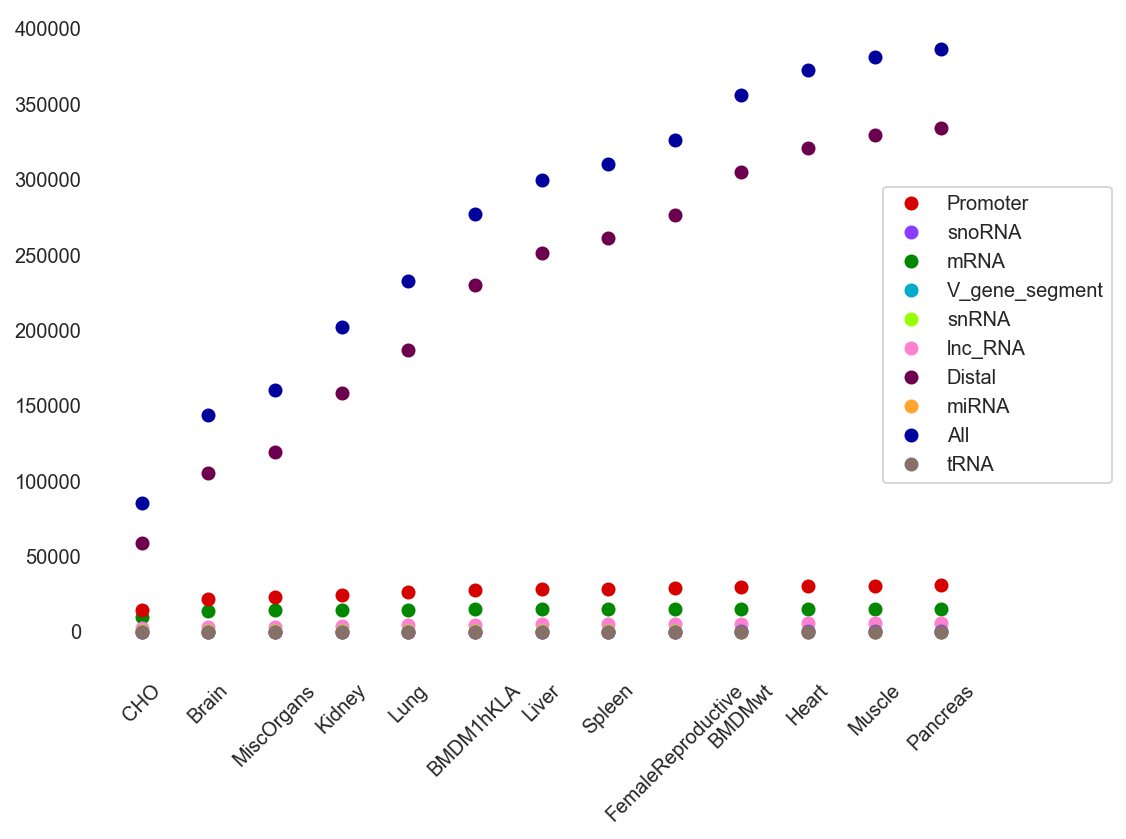

In [24]:
f, ax = plt.subplots()
for ind, val in df.iterrows():
    plot_cum(val.values, df.columns,f_save=None, ax=ax, c=np.array([colors[ind],]))
    #plt.scatter(np.arange(len(val.values)val.values)
legend_from_color(colors, curr_ax = ax)
helper_save(cumulative_f)

## B. Venn Diagram Between CHO and other

In [25]:
def get_venn(peaks, group_A_list, group_B_list, return_sets = False):
    group_A_peaks = set()
    for i in group_A_list:
        group_A_peaks = group_A_peaks.union(peaks[i])

    group_B_peaks = set()
    for i in group_B_list:
        group_B_peaks = group_B_peaks.union(peaks[i])
    
    if return_sets:
        return group_A_peaks, group_B_peaks
    else:
        # Venn Diagram
        a = group_A_peaks - group_B_peaks
        b = group_B_peaks - group_A_peaks
        overlap = group_B_peaks.intersection(group_A_peaks)
        return a, b, overlap

In [26]:
#venn = pd.DataFrame(index=["mRNA", "Distal", "ATAC"], columns=["CHO","Tissues", "Overlap"])
venn = pd.DataFrame(index=list(all_peaks.keys()), columns=["CHO","Tissues", "Overlap"])
venn = venn.loc[df.drop('All').index]

cho = ["CHO"]
tissues_group = list(filter(lambda x: x != "CHO", tissues))
for ind, val in venn.iterrows():
    a, b, overlap = get_venn(all_peaks[ind], cho, tissues_group)
    venn.at[ind,"CHO"] = a
    venn.at[ind,"Tissues"] = b
    venn.at[ind,"Overlap"] = overlap
    
venn_n = venn.applymap(lambda x: len(x), )
venn_n.loc["All"] = venn_n.drop("mRNA").sum()


venn_n.to_csv(venn_f)
venn_n

,CHO,Tissues,Overlap
mRNA,198,5458,9652
Promoter,1521,16469,12770
Distal,42312,275066,16778
V_gene_segment,0,1,0
lnc_RNA,1303,3400,894
miRNA,4,80,6
snRNA,48,254,145
snoRNA,10,145,20
tRNA,0,2,1
All,45198,295417,30614


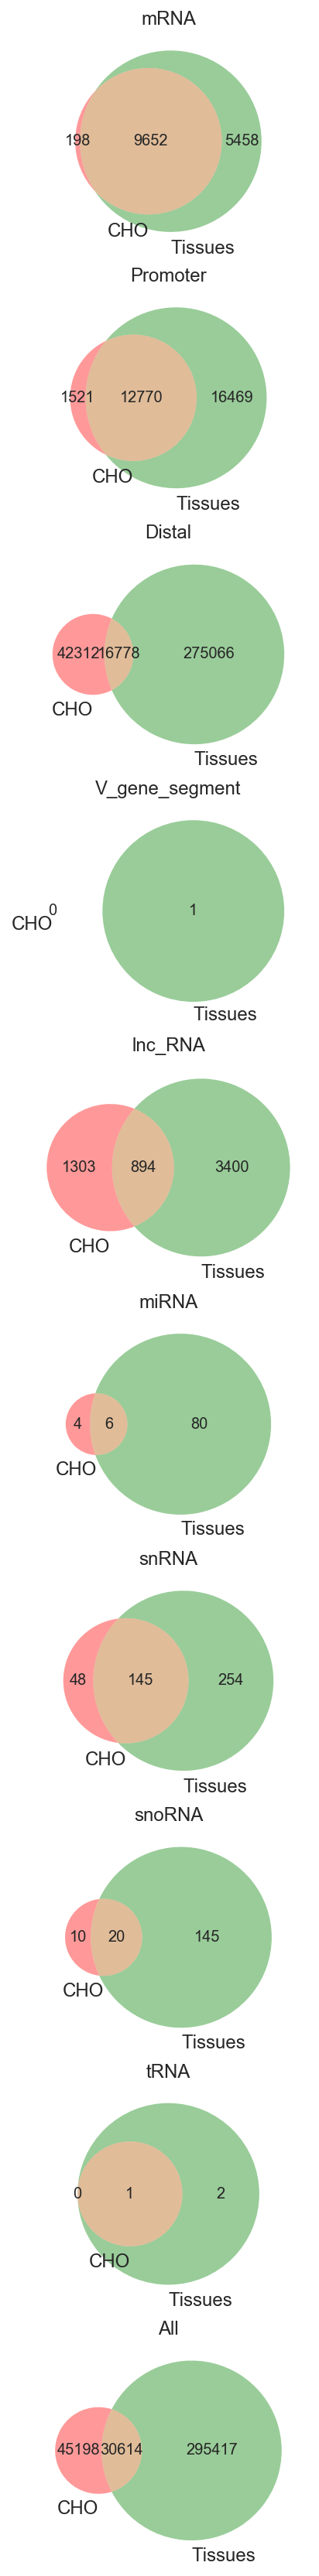

In [27]:
f, ax = plt.subplots(nrows=venn_n.shape[0],figsize=(30,30))

count=0
for ind, val in venn_n.iterrows():
    venn2(subsets=(val["CHO"], val["Tissues"], val["Overlap"]),set_labels=('CHO','Tissues'), ax=ax[count])
    ax[count].set_title(ind)
    count += 1

helper_save(venn_f)


## Add total genes for mRNA

6079


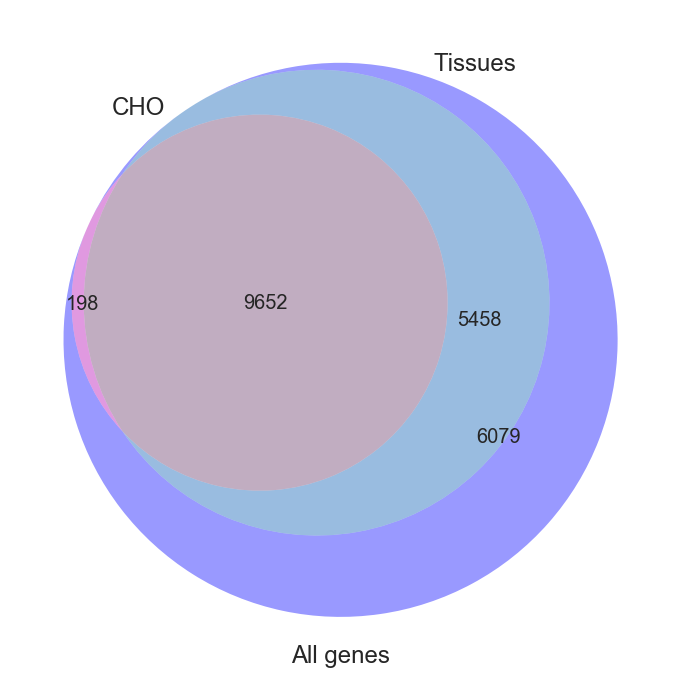

In [28]:
cho = ["CHO"]
tissues_group = list(filter(lambda x: x != "CHO", tissues))
cho_set, tissues_set = get_venn(all_peaks['mRNA'], cho, tissues_group,return_sets=True)

venn3(subsets=(cho_set, tissues_set, all_genes), set_labels=("CHO", "Tissues", "All genes"))
venn_all_genes_mrna_f = join(fig1_peaks, f"all_genes_peaks_venn_thresh{thresh}.csv")

helper_save(venn_all_genes_mrna_f)

genes_silenced = all_genes - cho_set - tissues_set
print(len(genes_silenced))
#print(genes_silenced)
with open(join(fig1_peaks, "genes_silenced.csv"),'w') as f:
    f.write("\n".join(list(genes_silenced)))
